<a href="https://colab.research.google.com/github/Freddy-94/1st_GAN/blob/main/First_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alfredo Bernal Luna
### August 4th 2024
### First GAN implementation

Import all the packages and libraries needed to run the model:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Second, we specify the input dimensions of our model and dataset. Each image in MNIST is 28 × 28 pixels with a single channel (because the images are grayscale). The variable z_dim sets the size of the noise vector, z:

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

Generator

In [ ]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))
    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))
    return model

Discriminator

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))
    # Fully connected layer
    model.add(Dense(128))
    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    return model

Build the model

In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()
    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Training

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()
    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))
    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(f"{iteration + 1} [D loss: {d_loss}, acc.: {100.0 * accuracy}] [G loss: {g_loss}]")

            # Output a sample of generated image
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

# Train the GAN and inspect output

Note that the 'Discrepancy between trainable weights and collected trainable' warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

Se truncaron las últimas líneas 5000 del resultado de transmisión.
4/4 [==============================] - 0s 2ms/step
18000 [D loss: 0.4349993020296097, acc.: 80.078125] [G loss: 2.4954187870025635]
4/4 [==============================] - 0s 2ms/step
19000 [D loss: 0.4420838803052902, acc.: 79.6875] [G loss: 2.265605926513672]
4/4 [==============================] - 0s 2ms/step
20000 [D loss: 0.5352460741996765, acc.: 77.734375] [G loss: 2.3341732025146484]
1/1 [==============================] - 0s 24ms/step


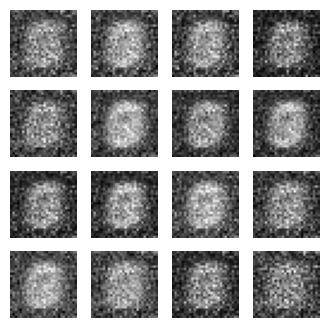

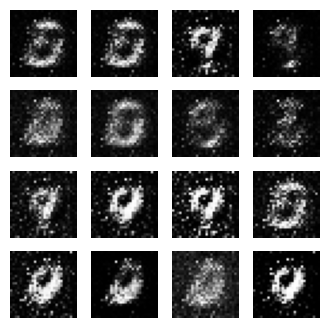

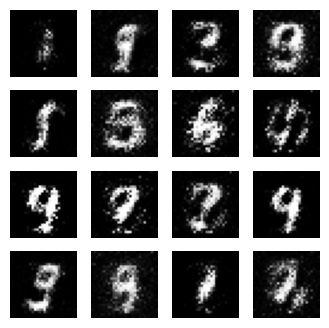

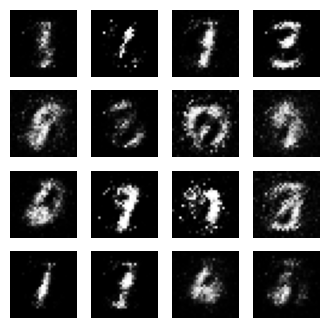

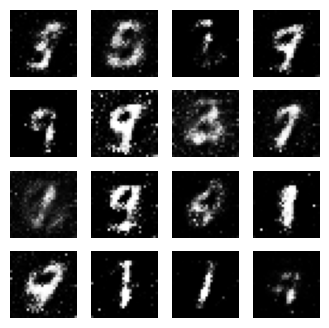

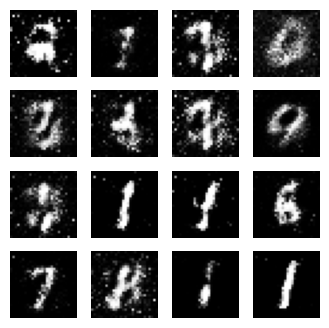

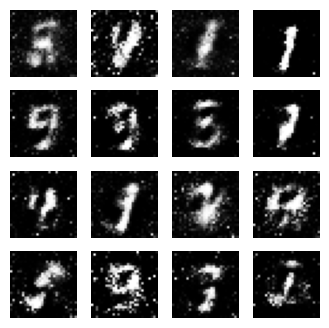

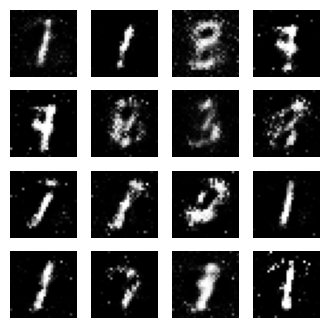

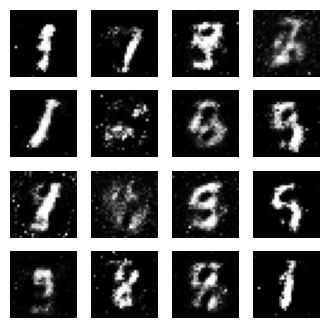

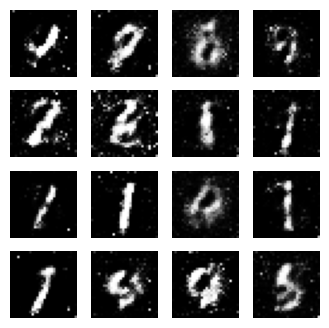

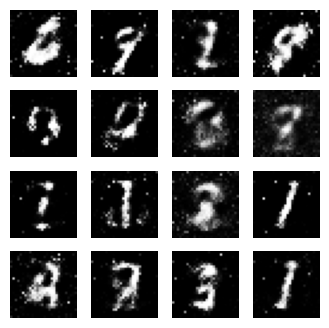

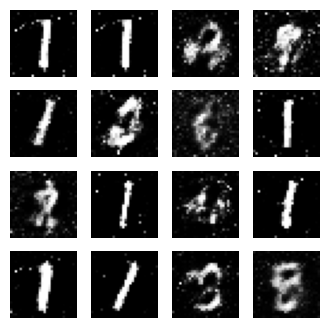

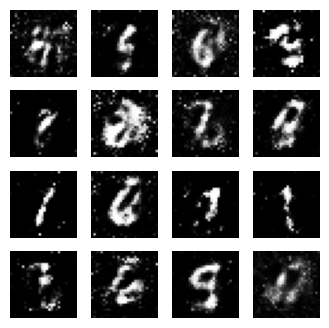

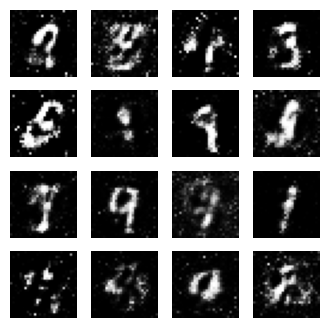

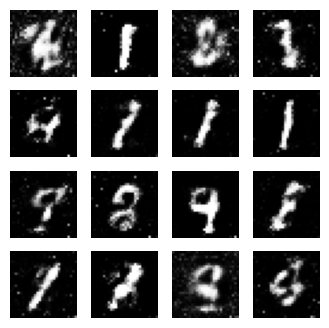

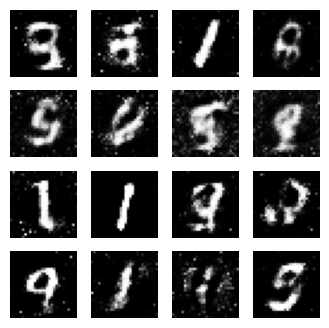

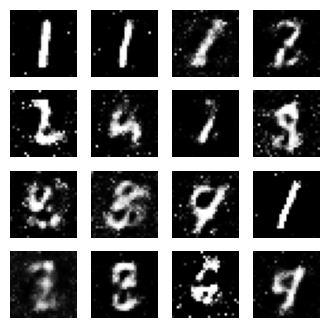

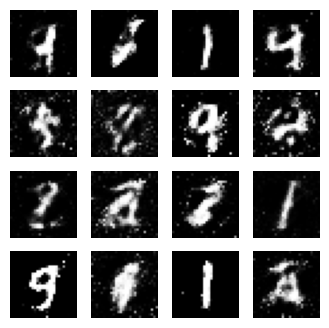

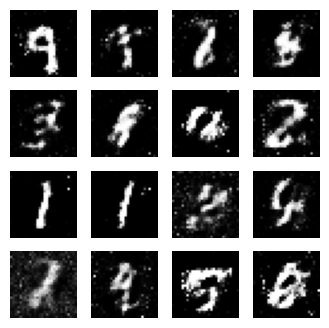

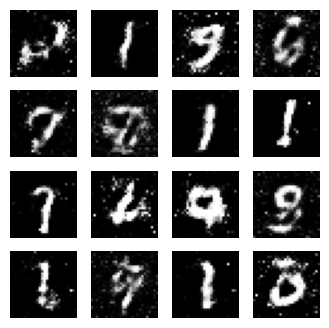

In [ ]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

There is no tried-and-true method to determine the right number of iterations or the right batch size; we determine them experimentally through trial and error as we observe the training progress.

That said, there are important practical constraints to these numbers: each minibatch must be small enough to fit inside the processing memory (typical batch sizes people use are powers of 2: 32, 64, 128, 256, and 512). The number of iterations also has a practical constraint: the more iterations we have, the longer the training process takes. With complex deep learning models like GANs, this can get out of hand quickly, even with significant computing power.

To determine the right number of iterations, we monitor the training loss and
set the iteration number around the point when the loss plateaus, indicating that we are getting little to no incremental improvement from further training. (Because this is a generative model, overfitting is as much a concern as it is for supervised learning algorithms.)